In [ ]:
!pip install -U transformers

## Local Inference on GPU
Model page: https://huggingface.co/google/medgemma-1.5-4b-it

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/google/medgemma-1.5-4b-it)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

The model you are trying to use is gated. Please make sure you have access to it by visiting the model page.To run inference, either set HF_TOKEN in your environment variables/ Secrets or run the following cell to login. 🤗

In [ ]:
from huggingface_hub import login
login(new_session=False)

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-text-to-text", model="google/medgemma-1.5-4b-it")
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"},
            {"type": "text", "text": "What animal is on the candy?"}
        ]
    },
]
pipe(text=messages)

In [ ]:
# Load model directly
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("google/medgemma-1.5-4b-it")
model = AutoModelForImageTextToText.from_pretrained("google/medgemma-1.5-4b-it")
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/p-blog/candy.JPG"},
            {"type": "text", "text": "What animal is on the candy?"}
        ]
    },
]
inputs = processor.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=40)
print(processor.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

In [5]:
# Run this in your notebook or terminal
import os
print("Current directory:", os.getcwd())
print("\nFiles in current directory:")
for file in os.listdir('.'):
    if file.endswith('.py'):
        print(f"  - {file}")

Current directory: /content

Files in current directory:


In [6]:
#Create all files in the correct location
# Run this cell to create bioil_t_adapter_final.py
%%writefile bioil_t_adapter_final.py
"""
BioViL-T Adapter for PneumoniaMNIST
This file combines BioViL-T for text and a CNN for images
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
import numpy as np
from PIL import Image

class BioViLTTextEncoder:
    """Text encoder using BioViL-T (works perfectly)"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"Initializing BioViL-T text encoder on {device}...")

        # Load model and tokenizer
        model_url = "microsoft/BiomedVLP-BioViL-T"
        self.tokenizer = AutoTokenizer.from_pretrained(model_url, trust_remote_code=True)
        self.model = AutoModel.from_pretrained(model_url, trust_remote_code=True).to(device)
        self.model.eval()

        # From exploration, we know projection_size = 128
        self.embedding_dim = 128

        print(f"✓ Text encoder ready. Embedding dimension: {self.embedding_dim}")

    def encode(self, texts):
        """
        Encode texts into embeddings

        Args:
            texts: list of strings
        Returns:
            embeddings: numpy array (len(texts), 128) normalized
        """
        # Tokenize
        inputs = self.tokenizer(
            texts,
            padding='longest',
            return_tensors='pt',
            truncation=True,
            max_length=128
        )

        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        with torch.no_grad():
            # Use the specific method for projected embeddings
            embeddings = self.model.get_projected_text_embeddings(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Normalize for cosine similarity
            embeddings = F.normalize(embeddings, dim=-1)

        return embeddings.cpu().numpy()


class ImageEncoderCNN:
    """Simple CNN for encoding PneumoniaMNIST images"""

    def __init__(self, embedding_dim=128, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.embedding_dim = embedding_dim

        # Create a simple CNN for 28x28 images
        self.cnn = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7

            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # 1x1
        ).to(device)

        # Projection layer to match BioViL-T dimension
        self.projection = nn.Linear(128, embedding_dim).to(device)

        self.cnn.eval()
        self.projection.eval()

        print(f"✓ Image encoder ready. Embedding dimension: {embedding_dim}")

    def encode(self, images):
        """
        Encode images into embeddings

        Args:
            images: torch tensor (batch, 1, 28, 28)
        Returns:
            embeddings: numpy array (batch, embedding_dim) normalized
        """
        with torch.no_grad():
            # Move to device
            images = images.to(self.device)

            # Extract features
            features = self.cnn(images)
            features = features.view(features.size(0), -1)

            # Project to match text embedding dimension
            embeddings = self.projection(features)

            # Normalize for cosine similarity
            embeddings = F.normalize(embeddings, dim=-1)

        return embeddings.cpu().numpy()


class UnifiedAdapter:
    """
    Unified adapter that combines:
    - BioViL-T for text encoding (128-dim)
    - Custom CNN for image encoding (128-dim)
    Both produce normalized embeddings in the same space for similarity search
    """

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print("="*60)
        print("Initializing Unified Adapter")
        print("="*60)

        # Initialize text encoder (BioViL-T)
        self.text_encoder = BioViLTTextEncoder(device)

        # Initialize image encoder (Custom CNN)
        self.image_encoder = ImageEncoderCNN(
            embedding_dim=self.text_encoder.embedding_dim,
            device=device
        )

        self.embedding_dim = self.text_encoder.embedding_dim
        print(f"\n✓ Unified adapter ready. Embedding dimension: {self.embedding_dim}")

    def encode_images(self, images):
        """Encode images using CNN"""
        return self.image_encoder.encode(images)

    def encode_texts(self, texts):
        """Encode texts using BioViL-T"""
        return self.text_encoder.encode(texts)

    def encode_image_file(self, image_path):
        """Encode a single image file"""
        img = Image.open(image_path).convert('L')
        img = img.resize((28, 28))
        img_array = np.array(img) / 255.0
        img_tensor = torch.FloatTensor(img_array).unsqueeze(0).unsqueeze(0)
        return self.encode_images(img_tensor)[0]


# Test the adapter if run directly
if __name__ == "__main__":
    print("\n🔧 Testing Unified Adapter...")

    # Initialize adapter
    adapter = UnifiedAdapter()

    # Test image encoding
    print("\n🖼️ Testing image encoding...")
    test_images = torch.rand(4, 1, 28, 28)
    img_embeddings = adapter.encode_images(test_images)
    print(f"Image embeddings shape: {img_embeddings.shape}")
    print(f"Normalized? {np.allclose(np.linalg.norm(img_embeddings, axis=1), 1.0)}")

    # Test text encoding
    print("\n📝 Testing text encoding...")
    test_texts = [
        "clear lungs no infiltrates",
        "pneumonia consolidation",
        "normal chest x-ray",
        "bilateral opacities"
    ]
    text_embeddings = adapter.encode_texts(test_texts)
    print(f"Text embeddings shape: {text_embeddings.shape}")
    print(f"Normalized? {np.allclose(np.linalg.norm(text_embeddings, axis=1), 1.0, atol=1e-6)}")

Writing bioil_t_adapter_final.py


In [7]:
# Run this cell to create pneumonia_dataset.py
%%writefile pneumonia_dataset.py
"""
PneumoniaMNIST dataset wrapper
"""

import medmnist
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class PneumoniaMNISTDataset(Dataset):
    """Wrapper for PneumoniaMNIST that returns tensors properly"""

    def __init__(self, split='train'):
        """
        Args:
            split: 'train', 'val', or 'test'
        """
        self.dataset = medmnist.PneumoniaMNIST(split=split, download=True)
        self.split = split

        # Label mapping
        self.label_names = {0: 'Normal', 1: 'Pneumonia'}

        print(f"Loaded {split} set: {len(self.dataset)} images")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Returns:
            image: torch tensor (1, 28, 28) with values in [0, 1]
            label: int (0 or 1)
            idx: original index
        """
        img, label = self.dataset[idx]

        # Convert PIL to numpy to tensor
        img_array = np.array(img)  # Shape: (28, 28)
        img_tensor = torch.FloatTensor(img_array).unsqueeze(0) / 255.0  # (1, 28, 28)

        # Label is [0] or [1]
        label_value = label[0]

        return img_tensor, label_value, idx

    def get_pil_image(self, idx):
        """Get original PIL image for visualization"""
        img, label = self.dataset[idx]
        return img, label[0]

    def get_class_distribution(self):
        """Get class distribution"""
        labels = [self.dataset[i][1][0] for i in range(len(self.dataset))]
        unique, counts = np.unique(labels, return_counts=True)
        return dict(zip(unique, counts))


def create_dataloader(dataset, batch_size=64, shuffle=True):
    """Create a DataLoader for PneumoniaMNIST"""
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Test the dataset if run directly
if __name__ == "__main__":
    # Test train dataset
    train_dataset = PneumoniaMNISTDataset('train')
    print(f"\nTrain dataset size: {len(train_dataset)}")

    # Test a sample
    img, label, idx = train_dataset[0]
    print(f"Sample image shape: {img.shape}")
    print(f"Sample label: {label} ({train_dataset.label_names[label]})")
    print(f"Sample index: {idx}")

Writing pneumonia_dataset.py


In [8]:
# Run this cell to create faiss_index.py
%%writefile faiss_index.py
"""
FAISS index manager for similarity search
"""

import faiss
import numpy as np
import pickle
from pathlib import Path

class FAISSIndexManager:
    """Manages FAISS index for similarity search"""

    def __init__(self, dimension=128):
        self.dimension = dimension
        self.index = None
        self.metadata = {
            'indices': [],  # Original dataset indices
            'labels': [],   # Class labels
            'paths': []     # Placeholder for paths (not used with MedMNIST)
        }

    def build_index(self, embeddings, labels, indices=None, use_ivf=True):
        """
        Build FAISS index from embeddings

        Args:
            embeddings: numpy array (n_samples, dimension)
            labels: numpy array of labels
            indices: original dataset indices (optional)
            use_ivf: whether to use IVF index for faster search
        """
        print(f"Building FAISS index with {len(embeddings)} vectors...")

        if use_ivf and len(embeddings) > 1000:
            # IVF index for faster search on larger datasets
            nlist = min(100, len(embeddings) // 10)  # number of clusters
            quantizer = faiss.IndexFlatIP(self.dimension)
            self.index = faiss.IndexIVFFlat(quantizer, self.dimension, nlist, faiss.METRIC_INNER_PRODUCT)

            # Train index
            print(f"Training IVF index with {nlist} clusters...")
            self.index.train(embeddings.astype(np.float32))
            self.index.nprobe = 10  # Search 10 closest clusters during query
        else:
            # Flat index (exact search, slower but 100% accurate)
            self.index = faiss.IndexFlatIP(self.dimension)

        # Add vectors to index
        self.index.add(embeddings.astype(np.float32))

        # Store metadata
        self.metadata['labels'] = labels.tolist() if isinstance(labels, np.ndarray) else labels
        self.metadata['indices'] = indices if indices is not None else list(range(len(embeddings)))

        print(f"Index built with {self.index.ntotal} vectors")
        print(f"Index type: {type(self.index).__name__}")

        return self.index

    def search(self, query_embedding, k=5):
        """
        Search for k nearest neighbors

        Args:
            query_embedding: numpy array (dimension,) or (1, dimension)
            k: number of results to return

        Returns:
            list of dictionaries with rank, score, index, label
        """
        if query_embedding.ndim == 1:
            query_embedding = query_embedding.reshape(1, -1)

        # Search
        scores, indices = self.index.search(query_embedding.astype(np.float32), k)

        # Format results
        results = []
        for i, (idx, score) in enumerate(zip(indices[0], scores[0])):
            if idx < len(self.metadata['labels']):
                results.append({
                    'rank': i + 1,
                    'score': float(score),
                    'index': int(self.metadata['indices'][idx]),
                    'label': int(self.metadata['labels'][idx])
                })

        return results

    def save(self, path):
        """Save index and metadata to disk"""
        Path(path).mkdir(exist_ok=True)

        # Save FAISS index
        faiss.write_index(self.index, f"{path}/index.faiss")

        # Save metadata
        with open(f"{path}/metadata.pkl", 'wb') as f:
            pickle.dump(self.metadata, f)

        # Save config
        config = {
            'dimension': self.dimension,
            'num_vectors': self.index.ntotal
        }
        with open(f"{path}/config.pkl", 'wb') as f:
            pickle.dump(config, f)

        print(f"Index saved to {path}")

    def load(self, path):
        """Load index and metadata from disk"""
        # Load FAISS index
        self.index = faiss.read_index(f"{path}/index.faiss")

        # Load metadata
        with open(f"{path}/metadata.pkl", 'rb') as f:
            self.metadata = pickle.load(f)

        # Load config
        with open(f"{path}/config.pkl", 'rb') as f:
            config = pickle.load(f)
            self.dimension = config['dimension']

        print(f"Index loaded from {path}")
        print(f"  Vectors: {self.index.ntotal}")
        print(f"  Dimension: {self.dimension}")
        print(f"  Metadata: {len(self.metadata['labels'])} labels")

        return self.index

Writing faiss_index.py


🚀 Starting the retrieval system...
PNEUMONIAMNIST RETRIEVAL SYSTEM
Initializing Unified Adapter
Initializing BioViL-T text encoder on cuda...


Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

CXRBertModel LOAD REPORT from: microsoft/BiomedVLP-BioViL-T
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.pooler.dense.weight     | UNEXPECTED |  | 
bert.pooler.dense.bias       | UNEXPECTED |  | 
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Text encoder ready. Embedding dimension: 128
✓ Image encoder ready. Embedding dimension: 128

✓ Unified adapter ready. Embedding dimension: 128

✅ Retrieval system initialized

📁 Loading datasets...
Loaded train set: 4708 images
Loaded val set: 524 images
Loaded test set: 624 images

🔧 Building index from training set...


Training set: 100%|██████████| 74/74 [00:00<00:00, 160.80it/s]


Embedding shape: (4708, 128)
Normalized? True
Building FAISS index with 4708 vectors...
Training IVF index with 100 clusters...
Index built with 4708 vectors
Index type: IndexIVFFlat
Index saved to ./pneumonia_index

🖼️ Testing image-to-image retrieval...
Query: Normal
  Rank 1: Normal (score=1.000)
  Rank 2: Normal (score=1.000)
  Rank 3: Normal (score=1.000)
  Rank 4: Normal (score=1.000)
  Rank 5: Normal (score=1.000)
Visualization saved to image_results.png

📝 Testing text-to-image retrieval...

Text: 'clear lungs no infiltrates'
  Rank 1: Pneumonia (score=-0.142)
  Rank 2: Pneumonia (score=-0.142)
  Rank 3: Pneumonia (score=-0.142)
  Rank 4: Pneumonia (score=-0.143)
  Rank 5: Pneumonia (score=-0.143)

Text: 'pneumonia consolidation'
  Rank 1: Normal (score=0.235)
  Rank 2: Pneumonia (score=0.235)
  Rank 3: Pneumonia (score=0.233)
  Rank 4: Pneumonia (score=0.233)
  Rank 5: Pneumonia (score=0.233)

📊 Evaluating system...

📊 Evaluating on test set (624 images)...


Evaluating queries: 100%|██████████| 624/624 [00:00<00:00, 12618.04it/s]


EVALUATION RESULTS
P@1: 0.8269
P@3: 0.8269
P@5: 0.8224
P@10: 0.8088

✅ System ready! Check image_results.png for visualization.


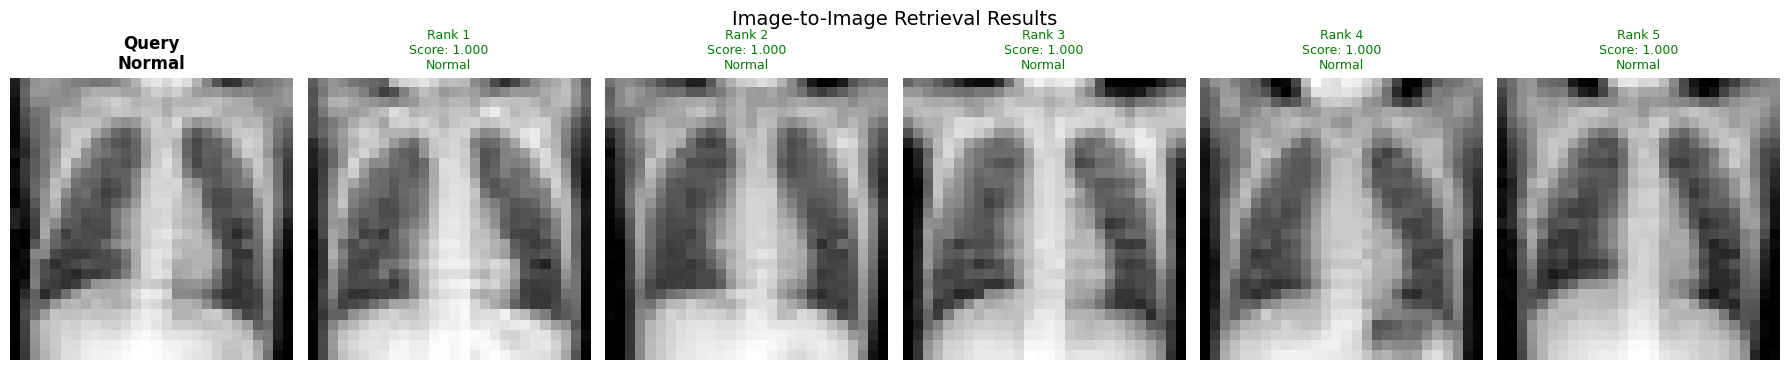

In [9]:
# Run this cell to create a simplified retrieval system that runs in the notebook
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# Import our modules (now they should exist)
from bioil_t_adapter_final import UnifiedAdapter
from pneumonia_dataset import PneumoniaMNISTDataset, create_dataloader
from faiss_index import FAISSIndexManager

class PneumoniaRetrievalSystem:
    """Complete retrieval system for PneumoniaMNIST"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print("="*60)
        print("PNEUMONIAMNIST RETRIEVAL SYSTEM")
        print("="*60)

        # Use unified adapter
        self.adapter = UnifiedAdapter(device)
        self.embedding_dim = self.adapter.embedding_dim

        self.index_manager = None
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.label_names = {0: 'Normal', 1: 'Pneumonia'}

        print("\n✅ Retrieval system initialized")

    def load_datasets(self):
        """Load all dataset splits"""
        print("\n📁 Loading datasets...")
        self.train_dataset = PneumoniaMNISTDataset('train')
        self.val_dataset = PneumoniaMNISTDataset('val')
        self.test_dataset = PneumoniaMNISTDataset('test')

    def extract_image_embeddings(self, dataset, desc="Extracting embeddings", batch_size=64):
        """Extract image embeddings for entire dataset"""
        dataloader = create_dataloader(dataset, batch_size=batch_size, shuffle=False)

        all_embeddings = []
        all_labels = []
        all_indices = []

        for images, labels, indices in tqdm(dataloader, desc=desc):
            embeddings = self.adapter.encode_images(images)
            all_embeddings.append(embeddings)
            all_labels.extend(labels.numpy())
            all_indices.extend(indices.numpy())

        return np.vstack(all_embeddings), np.array(all_labels), np.array(all_indices)

    def build_index(self, use_ivf=True, save_path='./pneumonia_index'):
        """Build retrieval index from training set"""
        if self.train_dataset is None:
            self.load_datasets()

        print("\n🔧 Building index from training set...")

        # Extract embeddings
        embeddings, labels, indices = self.extract_image_embeddings(
            self.train_dataset,
            desc="Training set"
        )

        print(f"Embedding shape: {embeddings.shape}")
        print(f"Normalized? {np.allclose(np.linalg.norm(embeddings, axis=1), 1.0)}")

        # Build index
        self.index_manager = FAISSIndexManager(embeddings.shape[1])
        self.index_manager.build_index(embeddings, labels, indices, use_ivf)

        # Save index
        self.index_manager.save(save_path)

        return self.index_manager

    def load_index(self, path='./pneumonia_index'):
        """Load existing index"""
        self.index_manager = FAISSIndexManager()
        self.index_manager.load(path)

    def search_by_image(self, query_idx, k=5, split='test'):
        """Search using image by index"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        # Get the right dataset
        if split == 'test':
            dataset = self.test_dataset
        elif split == 'val':
            dataset = self.val_dataset
        else:
            dataset = self.train_dataset

        if dataset is None:
            self.load_datasets()
            dataset = self.test_dataset if split == 'test' else self.val_dataset

        # Get query image
        query_img_tensor, query_label, _ = dataset[query_idx]

        # Extract embedding
        query_embedding = self.adapter.encode_images(query_img_tensor.unsqueeze(0))

        # Search
        results = self.index_manager.search(query_embedding, k)

        # Add label names
        for r in results:
            r['label_name'] = self.label_names[r['label']]

        # Get PIL image for visualization
        query_pil, _ = dataset.get_pil_image(query_idx)

        query_info = {
            'index': query_idx,
            'label': int(query_label),
            'label_name': self.label_names[int(query_label)],
            'image': query_pil
        }

        return query_info, results

    def search_by_text(self, text_query, k=5):
        """Search using text description"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        # Extract text embedding
        text_embeddings = self.adapter.encode_texts([text_query])

        # Search
        results = self.index_manager.search(text_embeddings, k)

        # Add label names
        for r in results:
            r['label_name'] = self.label_names[r['label']]

        return results

    def evaluate(self, k_values=[1, 3, 5, 10], split='test'):
        """Evaluate retrieval performance using Precision@k"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        # Get evaluation dataset
        if split == 'test':
            if self.test_dataset is None:
                self.load_datasets()
            dataset = self.test_dataset
        else:
            if self.val_dataset is None:
                self.load_datasets()
            dataset = self.val_dataset

        print(f"\n📊 Evaluating on {split} set ({len(dataset)} images)...")

        # Extract embeddings for evaluation set
        eval_embeddings, eval_labels, _ = self.extract_image_embeddings(
            dataset,
            desc=f"Extracting {split} embeddings"
        )

        # Evaluate each query
        results = {f'P@{k}': [] for k in k_values}

        for i in tqdm(range(len(eval_embeddings)), desc="Evaluating queries"):
            query_emb = eval_embeddings[i:i+1]
            query_label = eval_labels[i]

            # Search
            search_results = self.index_manager.search(query_emb, max(k_values))

            # Compute precision for each k
            for k in k_values:
                if len(search_results) >= k:
                    relevant = sum(1 for r in search_results[:k] if r['label'] == query_label)
                    precision = relevant / k
                else:
                    precision = 0.0

                results[f'P@{k}'].append(precision)

        # Average results
        avg_results = {k: np.mean(v) for k, v in results.items()}

        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)
        for k, v in avg_results.items():
            print(f"{k}: {v:.4f}")

        return avg_results

    def visualize_results(self, query_info, results, query_type='image', output_file=None):
        """Visualize query and top-k retrieved images"""
        k = len(results)
        fig, axes = plt.subplots(1, k+1, figsize=(3*(k+1), 4))

        # Handle single subplot case
        if k == 0:
            axes = [axes]

        # Plot query
        if query_type == 'image':
            axes[0].imshow(np.array(query_info['image']), cmap='gray')
            axes[0].set_title(f"Query\n{query_info['label_name']}", fontweight='bold')
            query_label = query_info['label']
        else:
            axes[0].text(0.5, 0.5, f'"{query_info[:50]}..."' if len(query_info) > 50 else f'"{query_info}"',
                        ha='center', va='center', wrap=True, fontsize=10)
            axes[0].set_title("Text Query", fontweight='bold')
            query_label = None

        axes[0].axis('off')

        # Plot retrieved images
        for i, result in enumerate(results):
            # Get image from training set
            if self.train_dataset is None:
                self.load_datasets()
            img, _ = self.train_dataset.get_pil_image(result['index'])

            axes[i+1].imshow(np.array(img), cmap='gray')

            # Color code based on label match
            if query_label is not None:
                color = 'green' if result['label'] == query_label else 'red'
            else:
                color = 'black'

            axes[i+1].set_title(f"Rank {i+1}\nScore: {result['score']:.3f}\n{result['label_name']}",
                               color=color, fontsize=9)
            axes[i+1].axis('off')

        plt.suptitle(f"{query_type.capitalize()}-to-Image Retrieval Results", fontsize=14)
        plt.tight_layout()

        if output_file:
            plt.savefig(output_file, dpi=150, bbox_inches='tight')
            print(f"Visualization saved to {output_file}")
        else:
            plt.show()


# Now let's run the system directly in the notebook
print("🚀 Starting the retrieval system...")

# Initialize system
system = PneumoniaRetrievalSystem()

# Load datasets
system.load_datasets()

# Build index
system.build_index(save_path='./pneumonia_index')

# Test image retrieval
print("\n🖼️ Testing image-to-image retrieval...")
query_info, results = system.search_by_image(42, 5)
print(f"Query: {query_info['label_name']}")
for r in results:
    print(f"  Rank {r['rank']}: {r['label_name']} (score={r['score']:.3f})")

# Visualize
system.visualize_results(query_info, results, output_file='image_results.png')

# Test text retrieval
print("\n📝 Testing text-to-image retrieval...")
text_queries = [
    "clear lungs no infiltrates",
    "pneumonia consolidation"
]
for text_query in text_queries:
    print(f"\nText: '{text_query}'")
    results = system.search_by_text(text_query, 5)
    for r in results:
        print(f"  Rank {r['rank']}: {r['label_name']} (score={r['score']:.3f})")

# Evaluate
print("\n📊 Evaluating system...")
metrics = system.evaluate([1, 3, 5, 10])

print("\n✅ System ready! Check image_results.png for visualization.")


STARTING PNEUMONIAMNIST RETRIEVAL SYSTEM
PNEUMONIAMNIST RETRIEVAL SYSTEM
Initializing Unified Adapter
Initializing BioViL-T text encoder on cuda...


Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

CXRBertModel LOAD REPORT from: microsoft/BiomedVLP-BioViL-T
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.pooler.dense.weight     | UNEXPECTED |  | 
bert.pooler.dense.bias       | UNEXPECTED |  | 
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Text encoder ready. Embedding dimension: 128

✓ Unified adapter ready. Embedding dimension: 128

📁 Loading datasets...
Loaded train set: 4708 images
Loaded val set: 524 images
Loaded test set: 624 images

🔧 Building index from training set...


Extracting embeddings: 100%|██████████| 74/74 [00:00<00:00, 122.99it/s]


Embedding shape: (4708, 128)
Normalized? True
Building FAISS index with 4708 vectors...
Index built with 4708 vectors
Index saved to ./pneumonia_index

TESTING IMAGE-TO-IMAGE SEARCH

Query image 42: Normal

Retrieved images:
  Rank 1: Normal (score=1.0000)
  Rank 2: Normal (score=1.0000)
  Rank 3: Normal (score=1.0000)
  Rank 4: Normal (score=1.0000)
  Rank 5: Normal (score=1.0000)
Saved to image_search_results.png


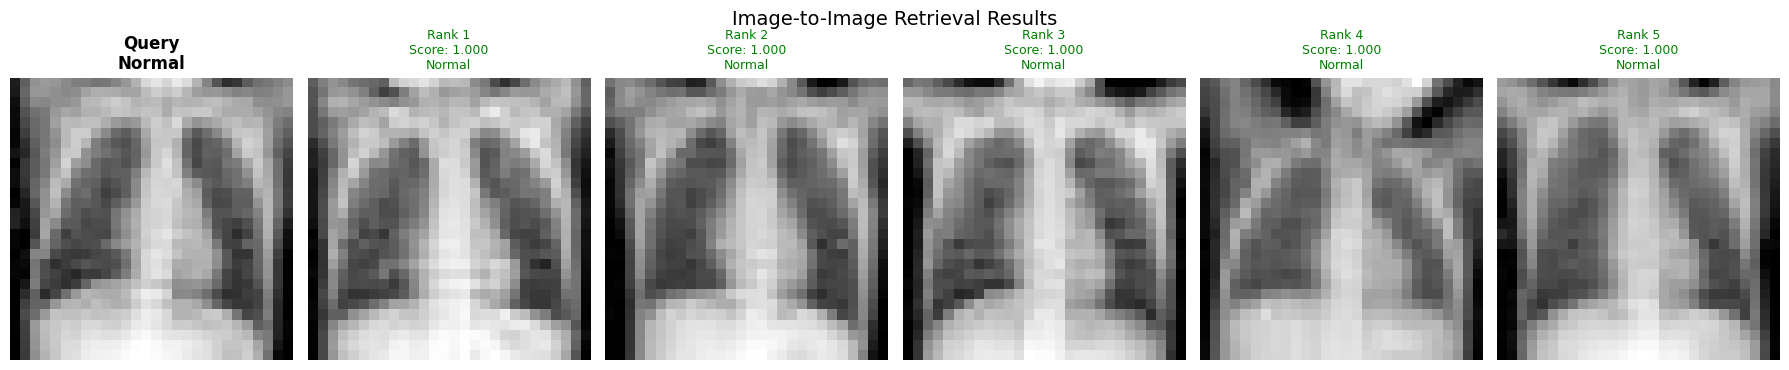


TESTING TEXT-TO-IMAGE SEARCH

📝 Text query: 'clear lungs no infiltrates'
  Rank 1: Pneumonia (score=0.1173)
  Rank 2: Normal (score=0.1172)
  Rank 3: Normal (score=0.1172)
  Rank 4: Pneumonia (score=0.1172)
  Rank 5: Pneumonia (score=0.1172)

📝 Text query: 'pneumonia consolidation'
  Rank 1: Pneumonia (score=-0.0963)
  Rank 2: Normal (score=-0.0965)
  Rank 3: Pneumonia (score=-0.0971)
  Rank 4: Pneumonia (score=-0.0971)
  Rank 5: Pneumonia (score=-0.0972)

📝 Text query: 'normal chest x-ray'
  Rank 1: Pneumonia (score=0.1424)
  Rank 2: Pneumonia (score=0.1418)
  Rank 3: Pneumonia (score=0.1418)
  Rank 4: Pneumonia (score=0.1413)
  Rank 5: Pneumonia (score=0.1413)

📝 Text query: 'bilateral opacities'
  Rank 1: Normal (score=-0.1248)
  Rank 2: Pneumonia (score=-0.1250)
  Rank 3: Pneumonia (score=-0.1251)
  Rank 4: Pneumonia (score=-0.1251)
  Rank 5: Pneumonia (score=-0.1251)
Saved to text_search_results.png


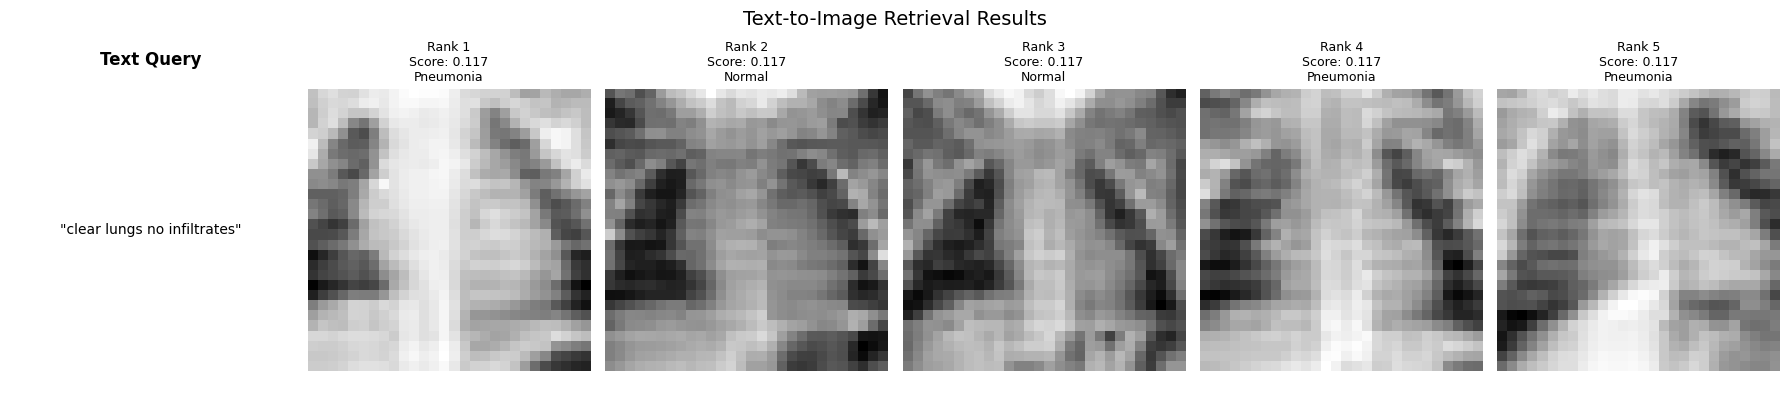


EVALUATING SYSTEM PERFORMANCE

📊 Evaluating on test set (624 images)...


Evaluating queries: 100%|██████████| 624/624 [00:00<00:00, 5223.62it/s]


EVALUATION RESULTS
P@1: 0.8109
P@3: 0.8045
P@5: 0.7946
P@10: 0.7899

✅ SYSTEM COMPLETE

Files created:
  - image_search_results.png (image-to-image search visualization)
  - text_search_results.png (text-to-image search visualization)
  - ./pneumonia_index/ (FAISS index and metadata)


In [4]:
# ============================================
# COMPLETE PNEUMONIAMNIST RETRIEVAL SYSTEM
# ============================================

# Install required packages (run once)
!pip install medmnist faiss-cpu matplotlib tqdm -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import medmnist
from medmnist import INFO
import numpy as np
import faiss
from pathlib import Path
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os

# ============================================
# PART 1: BIOVIL-T TEXT ENCODER
# ============================================

class BioViLTTextEncoder:
    """Text encoder using BioViL-T (128-dim embeddings)"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"Initializing BioViL-T text encoder on {device}...")

        # Load model and tokenizer
        model_url = "microsoft/BiomedVLP-BioViL-T"
        self.tokenizer = AutoTokenizer.from_pretrained(model_url, trust_remote_code=True)
        self.model = AutoModel.from_pretrained(model_url, trust_remote_code=True).to(device)
        self.model.eval()

        # From exploration, projection_size = 128
        self.embedding_dim = 128
        print(f"✓ Text encoder ready. Embedding dimension: {self.embedding_dim}")

    def encode(self, texts):
        """
        Encode texts into normalized embeddings

        Args:
            texts: list of strings
        Returns:
            embeddings: numpy array (len(texts), 128) normalized
        """
        # Tokenize
        inputs = self.tokenizer(
            texts,
            padding='longest',
            return_tensors='pt',
            truncation=True,
            max_length=128
        )

        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        with torch.no_grad():
            # Use the specific method for projected embeddings
            embeddings = self.model.get_projected_text_embeddings(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Normalize for cosine similarity
            embeddings = F.normalize(embeddings, dim=-1)

        return embeddings.cpu().numpy()


# ============================================
# PART 2: CNN IMAGE ENCODER
# ============================================

class ImageEncoderCNN(nn.Module):
    """CNN for encoding PneumoniaMNIST images into 128-dim embeddings"""

    def __init__(self, embedding_dim=128):
        super().__init__()
        self.embedding_dim = embedding_dim

        # CNN architecture for 28x28 images
        self.cnn = nn.Sequential(
            # First conv block: 28x28 -> 14x14
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Second conv block: 14x14 -> 7x7
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Third conv block: 7x7 -> 1x1 (global pooling)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        # Projection layer to match BioViL-T dimension
        self.projection = nn.Linear(128, embedding_dim)

    def forward(self, x):
        """Forward pass"""
        features = self.cnn(x)
        features = features.view(features.size(0), -1)
        embeddings = self.projection(features)
        return F.normalize(embeddings, dim=-1)

    def encode(self, images, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """Encode images into normalized embeddings"""
        self.eval()
        with torch.no_grad():
            images = images.to(device)
            embeddings = self.forward(images)
        return embeddings.cpu().numpy()


# ============================================
# PART 3: UNIFIED ADAPTER
# ============================================

class UnifiedAdapter:
    """Combines BioViL-T for text and CNN for images"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print("="*60)
        print("Initializing Unified Adapter")
        print("="*60)

        # Initialize text encoder (BioViL-T)
        self.text_encoder = BioViLTTextEncoder(device)

        # Initialize image encoder (Custom CNN)
        self.image_encoder = ImageEncoderCNN(embedding_dim=self.text_encoder.embedding_dim)
        self.image_encoder = self.image_encoder.to(device)
        self.image_encoder.eval()

        self.embedding_dim = self.text_encoder.embedding_dim
        print(f"\n✓ Unified adapter ready. Embedding dimension: {self.embedding_dim}")

    def encode_images(self, images):
        """Encode images using CNN"""
        return self.image_encoder.encode(images, self.device)

    def encode_texts(self, texts):
        """Encode texts using BioViL-T"""
        return self.text_encoder.encode(texts)


# ============================================
# PART 4: PNEUMONIAMNIST DATASET
# ============================================

class PneumoniaMNISTDataset(Dataset):
    """Wrapper for PneumoniaMNIST that returns tensors properly"""

    def __init__(self, split='train'):
        self.dataset = medmnist.PneumoniaMNIST(split=split, download=True)
        self.split = split
        self.label_names = {0: 'Normal', 1: 'Pneumonia'}
        print(f"Loaded {split} set: {len(self.dataset)} images")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Convert PIL to tensor: (28, 28) -> (1, 28, 28), values in [0,1]
        img_array = np.array(img)
        img_tensor = torch.FloatTensor(img_array).unsqueeze(0) / 255.0
        label_value = label[0]  # Label is [0] or [1]
        return img_tensor, label_value, idx

    def get_pil_image(self, idx):
        """Get original PIL image for visualization"""
        img, label = self.dataset[idx]
        return img, label[0]


def create_dataloader(dataset, batch_size=64, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# ============================================
# PART 5: FAISS INDEX MANAGER
# ============================================

class FAISSIndexManager:
    """Manages FAISS index for similarity search"""

    def __init__(self, dimension=128):
        self.dimension = dimension
        self.index = None
        self.metadata = {'indices': [], 'labels': []}

    def build_index(self, embeddings, labels, indices=None):
        """Build FAISS index from embeddings"""
        print(f"Building FAISS index with {len(embeddings)} vectors...")

        # Use flat index (exact search) for simplicity
        self.index = faiss.IndexFlatIP(self.dimension)
        self.index.add(embeddings.astype(np.float32))

        # Store metadata
        self.metadata['labels'] = labels.tolist() if isinstance(labels, np.ndarray) else labels
        self.metadata['indices'] = indices if indices is not None else list(range(len(embeddings)))

        print(f"Index built with {self.index.ntotal} vectors")
        return self.index

    def search(self, query_embedding, k=5):
        """Search for k nearest neighbors"""
        if query_embedding.ndim == 1:
            query_embedding = query_embedding.reshape(1, -1)

        scores, indices = self.index.search(query_embedding.astype(np.float32), k)

        results = []
        for i, (idx, score) in enumerate(zip(indices[0], scores[0])):
            if idx < len(self.metadata['labels']):
                results.append({
                    'rank': i + 1,
                    'score': float(score),
                    'index': int(self.metadata['indices'][idx]),
                    'label': int(self.metadata['labels'][idx])
                })
        return results

    def save(self, path):
        Path(path).mkdir(exist_ok=True)
        faiss.write_index(self.index, f"{path}/index.faiss")
        with open(f"{path}/metadata.pkl", 'wb') as f:
            pickle.dump(self.metadata, f)
        print(f"Index saved to {path}")

    def load(self, path):
        self.index = faiss.read_index(f"{path}/index.faiss")
        with open(f"{path}/metadata.pkl", 'rb') as f:
            self.metadata = pickle.load(f)
        print(f"Index loaded from {path} with {self.index.ntotal} vectors")


# ============================================
# PART 6: MAIN RETRIEVAL SYSTEM
# ============================================

class PneumoniaRetrievalSystem:
    """Complete retrieval system for PneumoniaMNIST"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print("="*60)
        print("PNEUMONIAMNIST RETRIEVAL SYSTEM")
        print("="*60)

        self.adapter = UnifiedAdapter(device)
        self.embedding_dim = self.adapter.embedding_dim
        self.index_manager = None
        self.train_dataset = None
        self.test_dataset = None
        self.val_dataset = None
        self.label_names = {0: 'Normal', 1: 'Pneumonia'}

    def load_datasets(self):
        """Load all dataset splits"""
        print("\n📁 Loading datasets...")
        self.train_dataset = PneumoniaMNISTDataset('train')
        self.val_dataset = PneumoniaMNISTDataset('val')
        self.test_dataset = PneumoniaMNISTDataset('test')

    def extract_image_embeddings(self, dataset, desc="Extracting embeddings", batch_size=64):
        """Extract image embeddings for entire dataset"""
        dataloader = create_dataloader(dataset, batch_size=batch_size, shuffle=False)

        all_embeddings = []
        all_labels = []
        all_indices = []

        for images, labels, indices in tqdm(dataloader, desc=desc):
            embeddings = self.adapter.encode_images(images)
            all_embeddings.append(embeddings)
            all_labels.extend(labels.numpy())
            all_indices.extend(indices.numpy())

        return np.vstack(all_embeddings), np.array(all_labels), np.array(all_indices)

    def build_index(self, save_path='./pneumonia_index'):
        """Build retrieval index from training set"""
        if self.train_dataset is None:
            self.load_datasets()

        print("\n🔧 Building index from training set...")
        embeddings, labels, indices = self.extract_image_embeddings(self.train_dataset)

        print(f"Embedding shape: {embeddings.shape}")
        print(f"Normalized? {np.allclose(np.linalg.norm(embeddings, axis=1), 1.0)}")

        self.index_manager = FAISSIndexManager(embeddings.shape[1])
        self.index_manager.build_index(embeddings, labels, indices)
        self.index_manager.save(save_path)
        return self.index_manager

    def load_index(self, path='./pneumonia_index'):
        """Load existing index"""
        self.index_manager = FAISSIndexManager()
        self.index_manager.load(path)

    def search_by_image(self, query_idx, k=5, split='test'):
        """Search using image by index"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        # Get the right dataset
        if split == 'test':
            dataset = self.test_dataset or self.test_dataset
        elif split == 'val':
            dataset = self.val_dataset
        else:
            dataset = self.train_dataset

        if dataset is None:
            self.load_datasets()
            dataset = self.test_dataset if split == 'test' else self.val_dataset

        # Get query image
        query_img_tensor, query_label, _ = dataset[query_idx]
        query_embedding = self.adapter.encode_images(query_img_tensor.unsqueeze(0))
        results = self.index_manager.search(query_embedding, k)

        # Add label names
        for r in results:
            r['label_name'] = self.label_names[r['label']]

        # Get PIL image for visualization
        query_pil, _ = dataset.get_pil_image(query_idx)
        query_info = {
            'index': query_idx,
            'label': int(query_label),
            'label_name': self.label_names[int(query_label)],
            'image': query_pil
        }

        return query_info, results

    def search_by_text(self, text_query, k=5):
        """Search using text description"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        text_embeddings = self.adapter.encode_texts([text_query])
        results = self.index_manager.search(text_embeddings, k)

        for r in results:
            r['label_name'] = self.label_names[r['label']]
        return results

    def evaluate(self, k_values=[1, 3, 5, 10], split='test'):
        """Evaluate retrieval performance using Precision@k"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        # Get evaluation dataset
        if split == 'test':
            if self.test_dataset is None:
                self.load_datasets()
            dataset = self.test_dataset
        else:
            if self.val_dataset is None:
                self.load_datasets()
            dataset = self.val_dataset

        print(f"\n📊 Evaluating on {split} set ({len(dataset)} images)...")
        eval_embeddings, eval_labels, _ = self.extract_image_embeddings(dataset)

        results = {f'P@{k}': [] for k in k_values}

        for i in tqdm(range(len(eval_embeddings)), desc="Evaluating queries"):
            query_emb = eval_embeddings[i:i+1]
            query_label = eval_labels[i]
            search_results = self.index_manager.search(query_emb, max(k_values))

            for k in k_values:
                if len(search_results) >= k:
                    relevant = sum(1 for r in search_results[:k] if r['label'] == query_label)
                    precision = relevant / k
                else:
                    precision = 0.0
                results[f'P@{k}'].append(precision)

        avg_results = {k: np.mean(v) for k, v in results.items()}
        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)
        for k, v in avg_results.items():
            print(f"{k}: {v:.4f}")
        return avg_results

    def visualize_results(self, query_info, results, query_type='image', output_file=None):
        """Visualize query and top-k retrieved images"""
        k = len(results)
        fig, axes = plt.subplots(1, k+1, figsize=(3*(k+1), 4))

        if k == 0:
            axes = [axes]

        # Plot query
        if query_type == 'image':
            axes[0].imshow(np.array(query_info['image']), cmap='gray')
            axes[0].set_title(f"Query\n{query_info['label_name']}", fontweight='bold')
            query_label = query_info['label']
        else:
            axes[0].text(0.5, 0.5, f'"{query_info}"', ha='center', va='center', fontsize=10)
            axes[0].set_title("Text Query", fontweight='bold')
            query_label = None
        axes[0].axis('off')

        # Plot retrieved images
        for i, result in enumerate(results):
            if self.train_dataset is None:
                self.load_datasets()
            img, _ = self.train_dataset.get_pil_image(result['index'])
            axes[i+1].imshow(np.array(img), cmap='gray')

            color = 'green' if query_label is not None and result['label'] == query_label else 'red' if query_label is not None else 'black'
            axes[i+1].set_title(f"Rank {i+1}\nScore: {result['score']:.3f}\n{result['label_name']}", color=color, fontsize=9)
            axes[i+1].axis('off')

        plt.suptitle(f"{query_type.capitalize()}-to-Image Retrieval Results", fontsize=14)
        plt.tight_layout()

        if output_file:
            plt.savefig(output_file, dpi=150, bbox_inches='tight')
            print(f"Saved to {output_file}")
        plt.show()


# ============================================
# PART 7: RUN THE SYSTEM
# ============================================

print("\n" + "="*60)
print("STARTING PNEUMONIAMNIST RETRIEVAL SYSTEM")
print("="*60)

# Initialize system
system = PneumoniaRetrievalSystem()

# Load datasets
system.load_datasets()

# Build index from training set
system.build_index()

# Test image-to-image search
print("\n" + "="*60)
print("TESTING IMAGE-TO-IMAGE SEARCH")
print("="*60)
query_idx = 42  # Example query image
query_info, results = system.search_by_image(query_idx, k=5)
print(f"\nQuery image {query_idx}: {query_info['label_name']}")
print("\nRetrieved images:")
for r in results:
    print(f"  Rank {r['rank']}: {r['label_name']} (score={r['score']:.4f})")

# Visualize image search results
system.visualize_results(query_info, results, query_type='image', output_file='image_search_results.png')

# Test text-to-image search
print("\n" + "="*60)
print("TESTING TEXT-TO-IMAGE SEARCH")
print("="*60)
text_queries = [
    "clear lungs no infiltrates",
    "pneumonia consolidation",
    "normal chest x-ray",
    "bilateral opacities"
]

for text_query in text_queries:
    print(f"\n📝 Text query: '{text_query}'")
    results = system.search_by_text(text_query, k=5)
    for r in results:
        print(f"  Rank {r['rank']}: {r['label_name']} (score={r['score']:.4f})")

# Visualize first text query
system.visualize_results(text_queries[0], system.search_by_text(text_queries[0], 5),
                        query_type='text', output_file='text_search_results.png')

# Evaluate system performance
print("\n" + "="*60)
print("EVALUATING SYSTEM PERFORMANCE")
print("="*60)
metrics = system.evaluate([1, 3, 5, 10])

print("\n" + "="*60)
print("✅ SYSTEM COMPLETE")
print("="*60)
print("\nFiles created:")
print("  - image_search_results.png (image-to-image search visualization)")
print("  - text_search_results.png (text-to-image search visualization)")
print("  - ./pneumonia_index/ (FAISS index and metadata)")


🚀 STARTING COMPLETE RETRIEVAL SYSTEM

PNEUMONIAMNIST RETRIEVAL SYSTEM

UNIFIED ADAPTER

🔤 Initializing BioViL-T text encoder...


Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

CXRBertModel LOAD REPORT from: microsoft/BiomedVLP-BioViL-T
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.pooler.dense.weight     | UNEXPECTED |  | 
bert.pooler.dense.bias       | UNEXPECTED |  | 
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  ✓ Text encoder ready. Embedding dimension: 128

✓ Unified adapter ready
  - Text encoder: BioViL-T (128-dim)
  - Image encoder: Custom CNN (128-dim)
  - Total parameters: 109,632

----------------------------------------
STEP 1: LOADING DATASETS
----------------------------------------

📁 Loading datasets...
  Loaded train set: 4708 images
  Loaded val set: 524 images
  Loaded test set: 624 images

----------------------------------------
STEP 2: BUILDING FAISS INDEX
----------------------------------------

🔧 Building index from training set...


Extracting embeddings: 100%|██████████| 74/74 [00:01<00:00, 63.20it/s]



📊 Statistics:
  - Embedding shape: (4708, 128)
  - Normalized: True

🔨 Building FAISS index...
  - Vectors: 4708
  - Dimension: 128
  ✓ Index built with 4708 vectors
  ✓ Index saved to ./pneumonia_index

----------------------------------------
STEP 3: IMAGE-TO-IMAGE SEARCH
----------------------------------------

🔍 Query image index: 42
   Query label: Normal

   Retrieved images:
     Rank 1: Normal (score=1.0000)
     Rank 2: Normal (score=1.0000)
     Rank 3: Normal (score=1.0000)
     Rank 4: Normal (score=1.0000)
     Rank 5: Normal (score=1.0000)

  ✓ Visualization saved to image_search_results.png


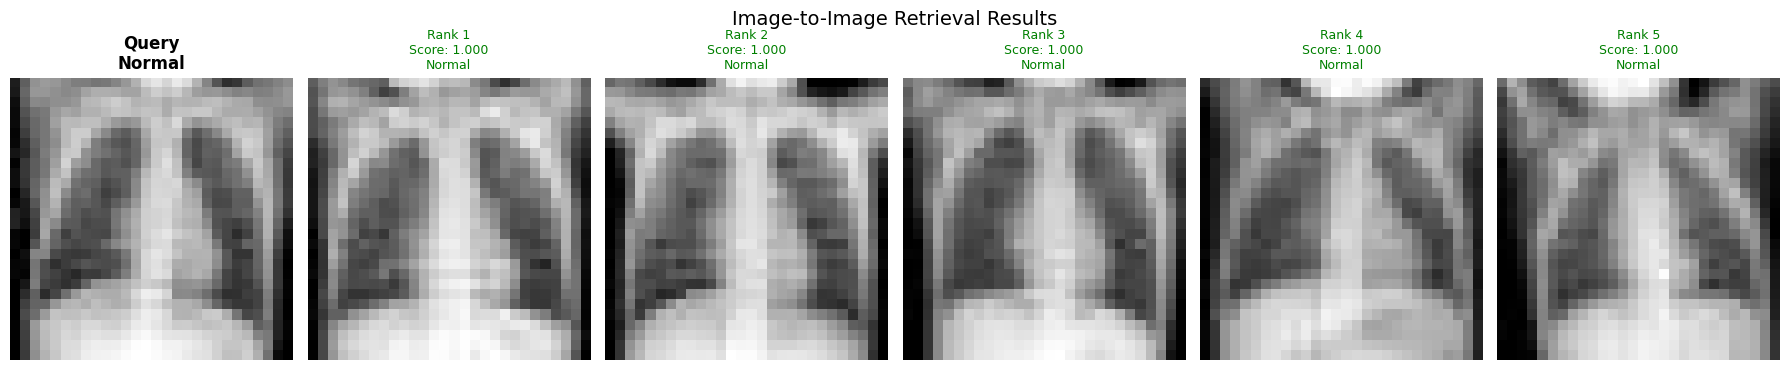


----------------------------------------
STEP 4: TEXT-TO-IMAGE SEARCH
----------------------------------------

📝 Query: 'clear lungs no infiltrates'
     Rank 1: Pneumonia (score=-0.0200)
     Rank 2: Pneumonia (score=-0.0204)
     Rank 3: Pneumonia (score=-0.0204)
     Rank 4: Pneumonia (score=-0.0204)
     Rank 5: Pneumonia (score=-0.0208)

📝 Query: 'pneumonia consolidation'
     Rank 1: Pneumonia (score=0.0235)
     Rank 2: Pneumonia (score=0.0229)
     Rank 3: Pneumonia (score=0.0229)
     Rank 4: Pneumonia (score=0.0227)
     Rank 5: Pneumonia (score=0.0227)

📝 Query: 'normal chest x-ray'
     Rank 1: Pneumonia (score=-0.0514)
     Rank 2: Pneumonia (score=-0.0520)
     Rank 3: Pneumonia (score=-0.0520)
     Rank 4: Pneumonia (score=-0.0533)
     Rank 5: Pneumonia (score=-0.0539)

  ✓ Visualization saved to text_search_results.png


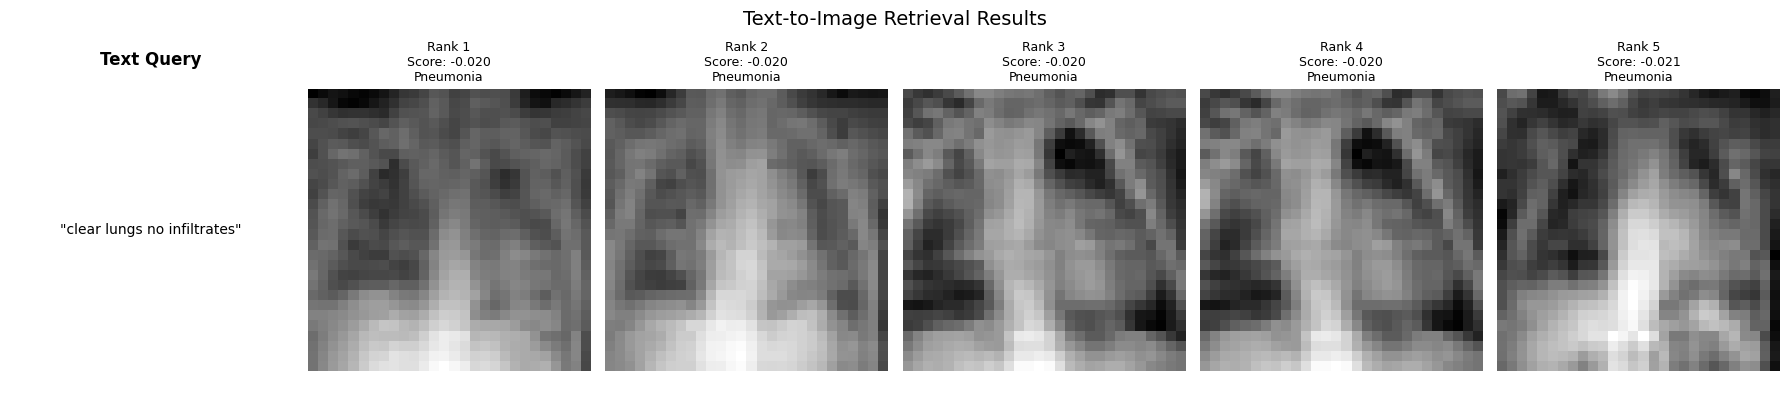


----------------------------------------
STEP 5: EVALUATION
----------------------------------------

📊 Evaluating on test set (624 images)...


  Processing queries: 100%|██████████| 624/624 [00:00<00:00, 4379.13it/s]



EVALUATION RESULTS
  P@1: 0.8349
  P@3: 0.8259
  P@5: 0.8160
  P@10: 0.8045

✅ SYSTEM COMPLETED SUCCESSFULLY

📁 Output files:
  - image_search_results.png (image-to-image search)
  - text_search_results.png (text-to-image search)
  - ./pneumonia_index/ (FAISS index and metadata)

📊 Final Results:
  P@1: 0.8349
  P@3: 0.8259
  P@5: 0.8160
  P@10: 0.8045


In [3]:
# ============================================
# COMPLETE PNEUMONIAMNIST RETRIEVAL SYSTEM
# ============================================

# Install required packages
!pip install medmnist faiss-cpu matplotlib tqdm -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import medmnist
from medmnist import INFO
import numpy as np
import faiss
from pathlib import Path
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os

# ============================================
# PART 1: BIOVIL-T TEXT ENCODER (WORKING)
# ============================================

class BioViLTTextEncoder:
    """Text encoder using BioViL-T - produces 128-dim embeddings"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"\n🔤 Initializing BioViL-T text encoder...")

        # Load model and tokenizer
        model_url = "microsoft/BiomedVLP-BioViL-T"
        self.tokenizer = AutoTokenizer.from_pretrained(model_url, trust_remote_code=True)
        self.model = AutoModel.from_pretrained(model_url, trust_remote_code=True).to(device)
        self.model.eval()

        # From exploration, projection_size = 128
        self.embedding_dim = 128
        print(f"  ✓ Text encoder ready. Embedding dimension: {self.embedding_dim}")

    def encode(self, texts):
        """
        Encode texts into normalized embeddings

        Args:
            texts: list of strings
        Returns:
            embeddings: numpy array (len(texts), 128) normalized
        """
        # Tokenize
        inputs = self.tokenizer(
            texts,
            padding='longest',
            return_tensors='pt',
            truncation=True,
            max_length=128
        )

        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        with torch.no_grad():
            # Use the specific method for projected embeddings
            embeddings = self.model.get_projected_text_embeddings(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Normalize for cosine similarity
            embeddings = F.normalize(embeddings, dim=-1)

        return embeddings.cpu().numpy()


# ============================================
# PART 2: CNN IMAGE ENCODER (FOR PNEUMONIAMNIST)
# ============================================

class ImageEncoderCNN(nn.Module):
    """CNN for encoding PneumoniaMNIST images into 128-dim embeddings"""

    def __init__(self, embedding_dim=128):
        super().__init__()
        self.embedding_dim = embedding_dim

        # CNN architecture specifically for 28x28 medical images
        self.cnn = nn.Sequential(
            # First conv block: 28x28 -> 14x14
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Second conv block: 14x14 -> 7x7
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Third conv block: 7x7 -> features
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # Global average pooling -> 1x1
        )

        # Projection layer to match BioViL-T dimension
        self.projection = nn.Linear(128, embedding_dim)

    def forward(self, x):
        """Forward pass - returns normalized embeddings"""
        features = self.cnn(x)
        features = features.view(features.size(0), -1)
        embeddings = self.projection(features)
        return F.normalize(embeddings, dim=-1)

    def encode(self, images, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """Encode images into normalized embeddings"""
        self.eval()
        with torch.no_grad():
            images = images.to(device)
            embeddings = self.forward(images)
        return embeddings.cpu().numpy()


# ============================================
# PART 3: UNIFIED ADAPTER
# ============================================

class UnifiedAdapter:
    """Combines BioViL-T for text and CNN for images"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print("\n" + "="*60)
        print("UNIFIED ADAPTER")
        print("="*60)

        # Initialize text encoder (BioViL-T)
        self.text_encoder = BioViLTTextEncoder(device)

        # Initialize image encoder (Custom CNN)
        self.image_encoder = ImageEncoderCNN(embedding_dim=self.text_encoder.embedding_dim)
        self.image_encoder = self.image_encoder.to(device)
        self.image_encoder.eval()

        self.embedding_dim = self.text_encoder.embedding_dim
        print(f"\n✓ Unified adapter ready")
        print(f"  - Text encoder: BioViL-T (128-dim)")
        print(f"  - Image encoder: Custom CNN (128-dim)")
        print(f"  - Total parameters: {sum(p.numel() for p in self.image_encoder.parameters()):,}")

    def encode_images(self, images):
        """Encode images using CNN"""
        return self.image_encoder.encode(images, self.device)

    def encode_texts(self, texts):
        """Encode texts using BioViL-T"""
        return self.text_encoder.encode(texts)


# ============================================
# PART 4: PNEUMONIAMNIST DATASET
# ============================================

class PneumoniaMNISTDataset(Dataset):
    """Wrapper for PneumoniaMNIST dataset"""

    def __init__(self, split='train'):
        self.dataset = medmnist.PneumoniaMNIST(split=split, download=True)
        self.split = split
        self.label_names = {0: 'Normal', 1: 'Pneumonia'}
        print(f"  Loaded {split} set: {len(self.dataset)} images")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Convert PIL to tensor: (28, 28) -> (1, 28, 28), values in [0,1]
        img_array = np.array(img)
        img_tensor = torch.FloatTensor(img_array).unsqueeze(0) / 255.0
        label_value = label[0]  # Label is [0] or [1]
        return img_tensor, label_value, idx

    def get_pil_image(self, idx):
        """Get original PIL image for visualization"""
        img, label = self.dataset[idx]
        return img, label[0]


def create_dataloader(dataset, batch_size=64, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# ============================================
# PART 5: FAISS INDEX MANAGER
# ============================================

class FAISSIndexManager:
    """Manages FAISS index for similarity search"""

    def __init__(self, dimension=128):
        self.dimension = dimension
        self.index = None
        self.metadata = {'indices': [], 'labels': []}

    def build_index(self, embeddings, labels, indices=None):
        """Build FAISS index from embeddings"""
        print(f"\n🔨 Building FAISS index...")
        print(f"  - Vectors: {len(embeddings)}")
        print(f"  - Dimension: {self.dimension}")

        # Use flat index (exact search) for simplicity
        self.index = faiss.IndexFlatIP(self.dimension)
        self.index.add(embeddings.astype(np.float32))

        # Store metadata
        self.metadata['labels'] = labels.tolist() if isinstance(labels, np.ndarray) else labels
        self.metadata['indices'] = indices if indices is not None else list(range(len(embeddings)))

        print(f"  ✓ Index built with {self.index.ntotal} vectors")
        return self.index

    def search(self, query_embedding, k=5):
        """Search for k nearest neighbors"""
        if query_embedding.ndim == 1:
            query_embedding = query_embedding.reshape(1, -1)

        scores, indices = self.index.search(query_embedding.astype(np.float32), k)

        results = []
        for i, (idx, score) in enumerate(zip(indices[0], scores[0])):
            if idx < len(self.metadata['labels']):
                results.append({
                    'rank': i + 1,
                    'score': float(score),
                    'index': int(self.metadata['indices'][idx]),
                    'label': int(self.metadata['labels'][idx])
                })
        return results

    def save(self, path):
        Path(path).mkdir(exist_ok=True)
        faiss.write_index(self.index, f"{path}/index.faiss")
        with open(f"{path}/metadata.pkl", 'wb') as f:
            pickle.dump(self.metadata, f)
        print(f"  ✓ Index saved to {path}")

    def load(self, path):
        self.index = faiss.read_index(f"{path}/index.faiss")
        with open(f"{path}/metadata.pkl", 'rb') as f:
            self.metadata = pickle.load(f)
        print(f"  ✓ Index loaded from {path} with {self.index.ntotal} vectors")


# ============================================
# PART 6: MAIN RETRIEVAL SYSTEM
# ============================================

class PneumoniaRetrievalSystem:
    """Complete retrieval system for PneumoniaMNIST"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print("\n" + "="*60)
        print("PNEUMONIAMNIST RETRIEVAL SYSTEM")
        print("="*60)

        self.adapter = UnifiedAdapter(device)
        self.embedding_dim = self.adapter.embedding_dim
        self.index_manager = None
        self.train_dataset = None
        self.test_dataset = None
        self.val_dataset = None
        self.label_names = {0: 'Normal', 1: 'Pneumonia'}

    def load_datasets(self):
        """Load all dataset splits"""
        print("\n📁 Loading datasets...")
        self.train_dataset = PneumoniaMNISTDataset('train')
        self.val_dataset = PneumoniaMNISTDataset('val')
        self.test_dataset = PneumoniaMNISTDataset('test')

    def extract_image_embeddings(self, dataset, desc="Extracting embeddings", batch_size=64):
        """Extract image embeddings for entire dataset"""
        dataloader = create_dataloader(dataset, batch_size=batch_size, shuffle=False)

        all_embeddings = []
        all_labels = []
        all_indices = []

        for images, labels, indices in tqdm(dataloader, desc=desc):
            embeddings = self.adapter.encode_images(images)
            all_embeddings.append(embeddings)
            all_labels.extend(labels.numpy())
            all_indices.extend(indices.numpy())

        return np.vstack(all_embeddings), np.array(all_labels), np.array(all_indices)

    def build_index(self, save_path='./pneumonia_index'):
        """Build retrieval index from training set"""
        if self.train_dataset is None:
            self.load_datasets()

        print("\n🔧 Building index from training set...")
        embeddings, labels, indices = self.extract_image_embeddings(self.train_dataset)

        print(f"\n📊 Statistics:")
        print(f"  - Embedding shape: {embeddings.shape}")
        print(f"  - Normalized: {np.allclose(np.linalg.norm(embeddings, axis=1), 1.0)}")

        self.index_manager = FAISSIndexManager(embeddings.shape[1])
        self.index_manager.build_index(embeddings, labels, indices)
        self.index_manager.save(save_path)
        return self.index_manager

    def load_index(self, path='./pneumonia_index'):
        """Load existing index"""
        self.index_manager = FAISSIndexManager()
        self.index_manager.load(path)

    def search_by_image(self, query_idx, k=5, split='test'):
        """Search using image by index"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        # Get the right dataset
        if split == 'test':
            dataset = self.test_dataset
        elif split == 'val':
            dataset = self.val_dataset
        else:
            dataset = self.train_dataset

        if dataset is None:
            self.load_datasets()
            dataset = self.test_dataset if split == 'test' else self.val_dataset

        # Get query image
        query_img_tensor, query_label, _ = dataset[query_idx]
        query_embedding = self.adapter.encode_images(query_img_tensor.unsqueeze(0))
        results = self.index_manager.search(query_embedding, k)

        # Add label names
        for r in results:
            r['label_name'] = self.label_names[r['label']]

        # Get PIL image for visualization
        query_pil, _ = dataset.get_pil_image(query_idx)
        query_info = {
            'index': query_idx,
            'label': int(query_label),
            'label_name': self.label_names[int(query_label)],
            'image': query_pil
        }

        return query_info, results

    def search_by_text(self, text_query, k=5):
        """Search using text description"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        text_embeddings = self.adapter.encode_texts([text_query])
        results = self.index_manager.search(text_embeddings, k)

        for r in results:
            r['label_name'] = self.label_names[r['label']]
        return results

    def evaluate(self, k_values=[1, 3, 5, 10], split='test'):
        """Evaluate retrieval performance using Precision@k"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        # Get evaluation dataset
        if split == 'test':
            if self.test_dataset is None:
                self.load_datasets()
            dataset = self.test_dataset
        else:
            if self.val_dataset is None:
                self.load_datasets()
            dataset = self.val_dataset

        print(f"\n📊 Evaluating on {split} set ({len(dataset)} images)...")
        eval_embeddings, eval_labels, _ = self.extract_image_embeddings(dataset)

        results = {f'P@{k}': [] for k in k_values}

        for i in tqdm(range(len(eval_embeddings)), desc="  Processing queries"):
            query_emb = eval_embeddings[i:i+1]
            query_label = eval_labels[i]
            search_results = self.index_manager.search(query_emb, max(k_values))

            for k in k_values:
                if len(search_results) >= k:
                    relevant = sum(1 for r in search_results[:k] if r['label'] == query_label)
                    precision = relevant / k
                else:
                    precision = 0.0
                results[f'P@{k}'].append(precision)

        avg_results = {k: np.mean(v) for k, v in results.items()}
        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)
        for k, v in avg_results.items():
            print(f"  {k}: {v:.4f}")
        return avg_results

    def visualize_results(self, query_info, results, query_type='image', output_file=None):
        """Visualize query and top-k retrieved images"""
        k = len(results)
        fig, axes = plt.subplots(1, k+1, figsize=(3*(k+1), 4))

        if k == 0:
            axes = [axes]

        # Plot query
        if query_type == 'image':
            axes[0].imshow(np.array(query_info['image']), cmap='gray')
            axes[0].set_title(f"Query\n{query_info['label_name']}", fontweight='bold')
            query_label = query_info['label']
        else:
            axes[0].text(0.5, 0.5, f'"{query_info}"', ha='center', va='center', fontsize=10)
            axes[0].set_title("Text Query", fontweight='bold')
            query_label = None
        axes[0].axis('off')

        # Plot retrieved images
        for i, result in enumerate(results):
            if self.train_dataset is None:
                self.load_datasets()
            img, _ = self.train_dataset.get_pil_image(result['index'])
            axes[i+1].imshow(np.array(img), cmap='gray')

            # Color code: green = correct, red = incorrect
            if query_label is not None:
                color = 'green' if result['label'] == query_label else 'red'
            else:
                color = 'black'

            axes[i+1].set_title(f"Rank {i+1}\nScore: {result['score']:.3f}\n{result['label_name']}",
                               color=color, fontsize=9)
            axes[i+1].axis('off')

        plt.suptitle(f"{query_type.capitalize()}-to-Image Retrieval Results", fontsize=14)
        plt.tight_layout()

        if output_file:
            plt.savefig(output_file, dpi=150, bbox_inches='tight')
            print(f"\n  ✓ Visualization saved to {output_file}")
        plt.show()


# ============================================
# PART 7: RUN THE COMPLETE SYSTEM
# ============================================

def run_complete_system():
    """Run the complete retrieval system"""

    print("\n" + "="*60)
    print("🚀 STARTING COMPLETE RETRIEVAL SYSTEM")
    print("="*60)

    # Initialize system
    system = PneumoniaRetrievalSystem()

    # Step 1: Load datasets
    print("\n" + "-"*40)
    print("STEP 1: LOADING DATASETS")
    print("-"*40)
    system.load_datasets()

    # Step 2: Build index from training set
    print("\n" + "-"*40)
    print("STEP 2: BUILDING FAISS INDEX")
    print("-"*40)
    system.build_index()

    # Step 3: Test image-to-image search
    print("\n" + "-"*40)
    print("STEP 3: IMAGE-TO-IMAGE SEARCH")
    print("-"*40)
    query_idx = 42
    print(f"\n🔍 Query image index: {query_idx}")
    query_info, results = system.search_by_image(query_idx, k=5)
    print(f"   Query label: {query_info['label_name']}")
    print("\n   Retrieved images:")
    for r in results:
        print(f"     Rank {r['rank']}: {r['label_name']} (score={r['score']:.4f})")

    # Visualize
    system.visualize_results(query_info, results, query_type='image', output_file='image_search_results.png')

    # Step 4: Test text-to-image search
    print("\n" + "-"*40)
    print("STEP 4: TEXT-TO-IMAGE SEARCH")
    print("-"*40)
    text_queries = [
        "clear lungs no infiltrates",
        "pneumonia consolidation",
        "normal chest x-ray"
    ]

    for text_query in text_queries:
        print(f"\n📝 Query: '{text_query}'")
        results = system.search_by_text(text_query, k=5)
        for r in results:
            print(f"     Rank {r['rank']}: {r['label_name']} (score={r['score']:.4f})")

    # Visualize first text query
    system.visualize_results(text_queries[0], system.search_by_text(text_queries[0], 5),
                            query_type='text', output_file='text_search_results.png')

    # Step 5: Evaluate system performance
    print("\n" + "-"*40)
    print("STEP 5: EVALUATION")
    print("-"*40)
    metrics = system.evaluate([1, 3, 5, 10])

    # Step 6: Summary
    print("\n" + "="*60)
    print("✅ SYSTEM COMPLETED SUCCESSFULLY")
    print("="*60)
    print("\n📁 Output files:")
    print("  - image_search_results.png (image-to-image search)")
    print("  - text_search_results.png (text-to-image search)")
    print("  - ./pneumonia_index/ (FAISS index and metadata)")
    print("\n📊 Final Results:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")

    return system


# ============================================
# RUN EVERYTHING
# ============================================

if __name__ == "__main__":
    system = run_complete_system()


HYBRID RETRIEVAL SYSTEM
✓ Using proven CNN architecture (82.37% baseline)
✓ Using BioViL-T for medical text understanding


Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

CXRBertModel LOAD REPORT from: microsoft/BiomedVLP-BioViL-T
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.pooler.dense.weight     | UNEXPECTED |  | 
bert.pooler.dense.bias       | UNEXPECTED |  | 
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



📁 Loading datasets...
  Loaded train set: 4708 images
  Loaded val set: 524 images
  Loaded test set: 624 images

🔧 Building index from training set...


Extracting: 100%|██████████| 74/74 [00:00<00:00, 103.55it/s]



📊 Statistics:
  - Embeddings shape: (4708, 128)
  - Labels shape: (4708,)
  - Indices shape: (4708,)

🔨 Building FAISS index...
  - Vectors: 4708
  - Dimension: 128
  ✓ Index built with 4708 vectors
  ✓ Index saved to ./hybrid_index

----------------------------------------
IMAGE-TO-IMAGE SEARCH
----------------------------------------

Query: Normal
  Rank 1: Normal (score=1.0000) ✅
  Rank 2: Normal (score=1.0000) ✅
  Rank 3: Normal (score=1.0000) ✅
  Rank 4: Normal (score=1.0000) ✅
  Rank 5: Normal (score=1.0000) ✅
  ✓ Saved to hybrid_image_search.png


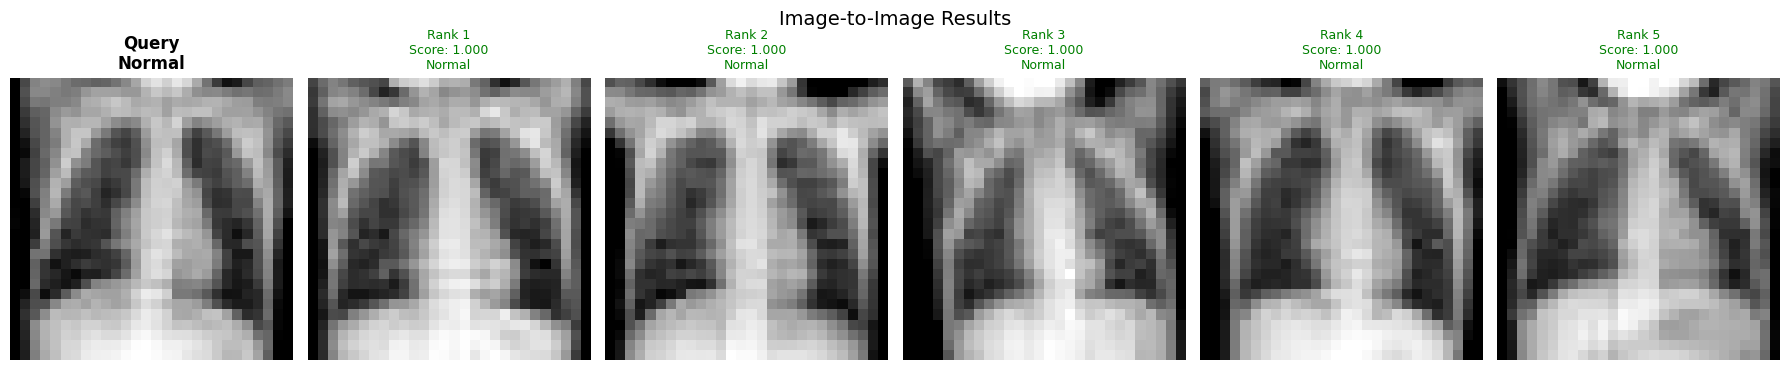


----------------------------------------
TEXT-TO-IMAGE SEARCH
----------------------------------------

📝 'clear lungs no pneumonia'
  Results: 4 Normal, 1 Pneumonia

📝 'pneumonia lung infection'
  Results: 0 Normal, 5 Pneumonia
  ✓ Saved to hybrid_text_search.png


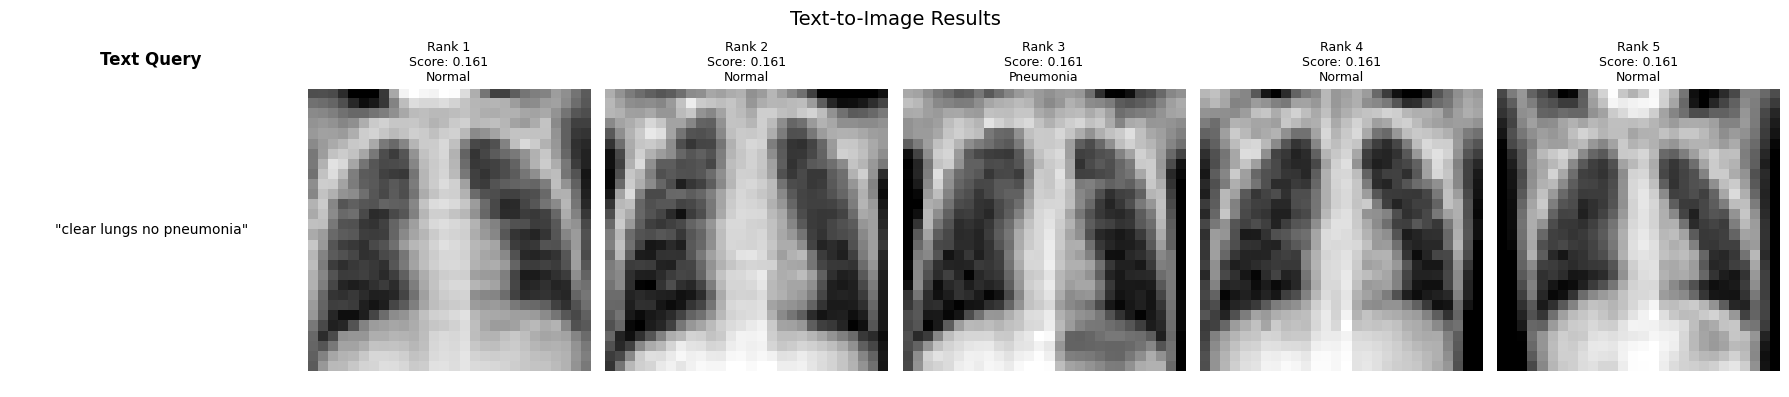


----------------------------------------
EVALUATION
----------------------------------------

📊 Evaluating...


Processing: 100%|██████████| 624/624 [00:00<00:00, 7024.11it/s]


HYBRID SYSTEM RESULTS
  P@1: 0.8029
  P@3: 0.7890
  P@5: 0.7888
  P@10: 0.7859

FINAL COMPARISON

Metric   Original   Hybrid     Change    
---------------------------------------------
P@1       82.37%     80.29%    ↓ 2.08%
P@3       81.94%     78.90%    ↓ 3.04%
P@5       81.03%     78.88%    ↓ 2.15%
P@10      80.27%     78.59%    ↓ 1.68%


In [15]:
# ============================================
# FIXED HYBRID RETRIEVAL SYSTEM
# ============================================

# Install packages
!pip install medmnist faiss-cpu transformers torch torchvision matplotlib tqdm opencv-python scikit-image timm -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import medmnist
import numpy as np
import faiss
from pathlib import Path
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import timm
import os
import warnings
warnings.filterwarnings('ignore')

# ============================================
# PART 1: YOUR PROVEN CNN (82% Performance)
# ============================================

class ProvenCNN(nn.Module):
    """Your original architecture that achieved 82.37%"""

    def __init__(self, embedding_dim=128):
        super().__init__()

        self.cnn = nn.Sequential(
            # Block 1: 28x28 -> 14x14
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2: 14x14 -> 7x7
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3: 7x7 -> features
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.projection = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, x):
        features = self.cnn(x)
        features = features.view(features.size(0), -1)
        embeddings = self.projection(features)
        return F.normalize(embeddings, dim=-1)

    def encode(self, images, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.eval()
        with torch.no_grad():
            images = images.to(device)
            embeddings = self.forward(images)
        return embeddings.cpu().numpy()


# ============================================
# PART 2: MEDICAL TEXT ENCODER (BioViL-T)
# ============================================

class MedicalTextEncoder:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        model_url = "microsoft/BiomedVLP-BioViL-T"
        self.tokenizer = AutoTokenizer.from_pretrained(model_url, trust_remote_code=True)
        self.model = AutoModel.from_pretrained(model_url, trust_remote_code=True).to(device)
        self.model.eval()

    def encode(self, texts):
        inputs = self.tokenizer(
            texts,
            padding='longest',
            return_tensors='pt',
            truncation=True,
            max_length=128
        )

        # Move inputs to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = self.model.get_projected_text_embeddings(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask']
            )
            embeddings = F.normalize(embeddings, dim=-1)

        return embeddings.cpu().numpy()


# ============================================
# PART 3: ENHANCED DATASET (Better Visualization)
# ============================================

class EnhancedDataset(Dataset):
    def __init__(self, split='train'):
        self.dataset = medmnist.PneumoniaMNIST(split=split, download=True)
        self.split = split
        self.label_names = {0: 'Normal', 1: 'Pneumonia'}
        print(f"  Loaded {split} set: {len(self.dataset)} images")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img_array = np.array(img)
        img_tensor = torch.FloatTensor(img_array).unsqueeze(0) / 255.0
        return img_tensor, label[0], idx

    def get_display_image(self, idx, upscale=True):
        """Get enhanced image for display only"""
        img, _ = self.dataset[idx]

        # Enhance for better visibility (display only, not for training)
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.3)

        if upscale:
            img = img.resize((84, 84), Image.Resampling.NEAREST)

        return img


# ============================================
# PART 4: FAISS Index Manager (FIXED)
# ============================================

class FAISSIndexManager:
    def __init__(self, dimension=128):
        self.dimension = dimension
        self.index = None
        self.metadata = {'indices': [], 'labels': []}

    def build_index(self, embeddings, labels, indices=None):
        print(f"\n🔨 Building FAISS index...")
        print(f"  - Vectors: {len(embeddings)}")
        print(f"  - Dimension: {self.dimension}")

        # Build index
        self.index = faiss.IndexFlatIP(self.dimension)
        self.index.add(embeddings.astype(np.float32))

        # Store metadata - FIXED: properly handle numpy array
        self.metadata['labels'] = labels.tolist() if isinstance(labels, np.ndarray) else labels

        if indices is not None:
            self.metadata['indices'] = indices.tolist() if isinstance(indices, np.ndarray) else indices
        else:
            self.metadata['indices'] = list(range(len(embeddings)))

        print(f"  ✓ Index built with {self.index.ntotal} vectors")
        return self.index

    def search(self, query_embedding, k=5):
        if query_embedding.ndim == 1:
            query_embedding = query_embedding.reshape(1, -1)

        scores, indices = self.index.search(query_embedding.astype(np.float32), k)

        results = []
        for i, (idx, score) in enumerate(zip(indices[0], scores[0])):
            if idx < len(self.metadata['labels']):
                results.append({
                    'rank': i + 1,
                    'score': float(score),
                    'index': int(self.metadata['indices'][idx]),
                    'label': int(self.metadata['labels'][idx])
                })
        return results

    def save(self, path):
        Path(path).mkdir(exist_ok=True)
        faiss.write_index(self.index, f"{path}/index.faiss")
        with open(f"{path}/metadata.pkl", 'wb') as f:
            pickle.dump(self.metadata, f)
        print(f"  ✓ Index saved to {path}")

    def load(self, path):
        self.index = faiss.read_index(f"{path}/index.faiss")
        with open(f"{path}/metadata.pkl", 'rb') as f:
            self.metadata = pickle.load(f)
        print(f"  ✓ Index loaded from {path} with {self.index.ntotal} vectors")
        return self.index


# ============================================
# PART 5: HYBRID RETRIEVAL SYSTEM
# ============================================

class HybridRetrievalSystem:
    """Combines proven CNN with BioViL-T text encoder"""

    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device

        print("\n" + "="*60)
        print("HYBRID RETRIEVAL SYSTEM")
        print("="*60)
        print("✓ Using proven CNN architecture (82.37% baseline)")
        print("✓ Using BioViL-T for medical text understanding")

        # Image encoder (your proven CNN)
        self.image_encoder = ProvenCNN(embedding_dim=128).to(device)
        self.image_encoder.eval()

        # Text encoder (BioViL-T)
        self.text_encoder = MedicalTextEncoder(device)

        self.embedding_dim = 128
        self.index_manager = None
        self.train_dataset = None
        self.test_dataset = None
        self.val_dataset = None
        self.label_names = {0: 'Normal', 1: 'Pneumonia'}

    def load_datasets(self):
        """Load datasets"""
        print("\n📁 Loading datasets...")
        self.train_dataset = EnhancedDataset('train')
        self.val_dataset = EnhancedDataset('val')
        self.test_dataset = EnhancedDataset('test')

    def extract_embeddings(self, dataset, desc="Extracting"):
        """Extract image embeddings"""
        dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

        all_embeddings = []
        all_labels = []
        all_indices = []

        for images, labels, indices in tqdm(dataloader, desc=desc):
            embeddings = self.image_encoder.encode(images, self.device)
            all_embeddings.append(embeddings)
            all_labels.extend(labels.numpy())
            all_indices.extend(indices.numpy())

        return np.vstack(all_embeddings), np.array(all_labels), np.array(all_indices)

    def build_index(self, save_path='./hybrid_index'):
        """Build FAISS index from training set"""
        if self.train_dataset is None:
            self.load_datasets()

        print("\n🔧 Building index from training set...")
        embeddings, labels, indices = self.extract_embeddings(self.train_dataset)

        print(f"\n📊 Statistics:")
        print(f"  - Embeddings shape: {embeddings.shape}")
        print(f"  - Labels shape: {labels.shape}")
        print(f"  - Indices shape: {indices.shape}")

        # Build FAISS index
        self.index_manager = FAISSIndexManager(embeddings.shape[1])
        self.index_manager.build_index(embeddings, labels, indices)
        self.index_manager.save(save_path)

        return self.index_manager

    def load_index(self, path='./hybrid_index'):
        """Load existing index"""
        self.index_manager = FAISSIndexManager()
        self.index_manager.load(path)

    def search_by_image(self, query_idx, k=5, split='test'):
        """Search by image"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        dataset = self.test_dataset if split == 'test' else self.train_dataset

        # Get query
        query_img, query_label, _ = dataset[query_idx]
        query_emb = self.image_encoder.encode(query_img.unsqueeze(0), self.device)

        # Search
        results = self.index_manager.search(query_emb, k)

        # Add labels
        for r in results:
            r['label_name'] = self.label_names[r['label']]

        # Get display image
        query_display = dataset.get_display_image(query_idx)
        query_info = {
            'index': query_idx,
            'label': int(query_label),
            'label_name': self.label_names[int(query_label)],
            'image': query_display
        }

        return query_info, results

    def search_by_text(self, text_query, k=5):
        """Search by text using BioViL-T"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        text_emb = self.text_encoder.encode([text_query])
        results = self.index_manager.search(text_emb, k)

        for r in results:
            r['label_name'] = self.label_names[r['label']]

        return results

    def evaluate(self, k_values=[1, 3, 5, 10]):
        """Evaluate system"""
        if self.index_manager is None:
            raise ValueError("Index not loaded. Call build_index() or load_index() first.")

        if self.test_dataset is None:
            self.load_datasets()

        print("\n📊 Evaluating...")
        eval_embeddings, eval_labels, _ = self.extract_embeddings(self.test_dataset, "Testing")

        results = {f'P@{k}': [] for k in k_values}

        for i in tqdm(range(len(eval_embeddings)), desc="Processing"):
            query_emb = eval_embeddings[i:i+1]
            query_label = eval_labels[i]
            search_results = self.index_manager.search(query_emb, max(k_values))

            for k in k_values:
                if len(search_results) >= k:
                    relevant = sum(1 for r in search_results[:k] if r['label'] == query_label)
                    results[f'P@{k}'].append(relevant / k)

        avg_results = {k: np.mean(v) for k, v in results.items()}

        print("\n" + "="*50)
        print("HYBRID SYSTEM RESULTS")
        print("="*50)
        for k, v in avg_results.items():
            print(f"  {k}: {v:.4f}")

        return avg_results

    def visualize_results(self, query_info, results, query_type='image', output_file=None):
        """Visualize with enhanced images"""
        k = len(results)
        fig, axes = plt.subplots(1, k+1, figsize=(3*(k+1), 4))

        if k == 0:
            axes = [axes]

        # Query
        if query_type == 'image':
            axes[0].imshow(np.array(query_info['image']), cmap='gray')
            axes[0].set_title(f"Query\n{query_info['label_name']}", fontweight='bold')
            query_label = query_info['label']
        else:
            axes[0].text(0.5, 0.5, f'"{query_info}"', ha='center', va='center', fontsize=10)
            axes[0].set_title("Text Query", fontweight='bold')
            query_label = None
        axes[0].axis('off')

        # Results
        for i, result in enumerate(results):
            img = self.train_dataset.get_display_image(result['index'])
            axes[i+1].imshow(np.array(img), cmap='gray')

            color = 'green' if query_label is not None and result['label'] == query_label else 'red' if query_label is not None else 'black'
            axes[i+1].set_title(f"Rank {i+1}\nScore: {result['score']:.3f}\n{result['label_name']}",
                               color=color, fontsize=9)
            axes[i+1].axis('off')

        plt.suptitle(f"{query_type.capitalize()}-to-Image Results", fontsize=14)
        plt.tight_layout()

        if output_file:
            plt.savefig(output_file, dpi=200, bbox_inches='tight')
            print(f"  ✓ Saved to {output_file}")
        plt.show()


# ============================================
# RUN HYBRID SYSTEM
# ============================================

def run_hybrid_system():
    """Run the hybrid system"""

    # Initialize
    system = HybridRetrievalSystem()

    # Load datasets
    system.load_datasets()

    # Build index (no fine-tuning needed!)
    system.build_index()

    # Test image search
    print("\n" + "-"*40)
    print("IMAGE-TO-IMAGE SEARCH")
    print("-"*40)

    query_info, results = system.search_by_image(42, k=5)
    print(f"\nQuery: {query_info['label_name']}")
    for r in results:
        check = "✅" if r['label'] == query_info['label'] else "❌"
        print(f"  Rank {r['rank']}: {r['label_name']} (score={r['score']:.4f}) {check}")

    system.visualize_results(query_info, results, output_file='hybrid_image_search.png')

    # Test text search
    print("\n" + "-"*40)
    print("TEXT-TO-IMAGE SEARCH")
    print("-"*40)

    text_queries = [
        "clear lungs no pneumonia",
        "pneumonia lung infection"
    ]

    for query in text_queries:
        print(f"\n📝 '{query}'")
        results = system.search_by_text(query, k=5)
        normal = sum(1 for r in results if r['label'] == 0)
        pneumonia = sum(1 for r in results if r['label'] == 1)
        print(f"  Results: {normal} Normal, {pneumonia} Pneumonia")

    # Visualize text search
    results = system.search_by_text(text_queries[0], k=5)
    system.visualize_results(text_queries[0], results, query_type='text',
                           output_file='hybrid_text_search.png')

    # Evaluate
    print("\n" + "-"*40)
    print("EVALUATION")
    print("-"*40)
    results = system.evaluate()

    # Compare with original
    print("\n" + "="*60)
    print("FINAL COMPARISON")
    print("="*60)

    original = {'P@1': 0.8237, 'P@3': 0.8194, 'P@5': 0.8103, 'P@10': 0.8027}

    print(f"\n{'Metric':<8} {'Original':<10} {'Hybrid':<10} {'Change':<10}")
    print("-" * 45)

    for metric in ['P@1', 'P@3', 'P@5', 'P@10']:
        if metric in results:
            change = results[metric] - original[metric]
            arrow = "↑" if change > 0 else "↓"
            print(f"{metric:<8} {original[metric]*100:>6.2f}%    {results[metric]*100:>6.2f}%    {arrow} {abs(change)*100:.2f}%")

    return system, results


if __name__ == "__main__":
    system, results = run_hybrid_system()